# Modeling and Evaluation

In [64]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)
import joblib

In [65]:
DATA_FEAT = Path("../data/features")
df = pd.read_parquet(DATA_FEAT / "url_features.parquet")


In [43]:
y = df['label'].astype(int)
X = df.drop(columns='label')

In [69]:
print("Dataset shape:", X.shape, "Target distribution:")
y.value_counts(normalize=True)

Dataset shape: (235795, 50) Target distribution:


label
1    0.571895
0    0.428105
Name: proportion, dtype: float64

In [70]:
# Define Models

In [81]:
logreg = Pipeline([
    ('scale', StandardScaler(with_mean=False)),  # Scaling only needed for LR
    ('model', LogisticRegression(max_iter=500, solver='liblinear'))
])

In [84]:
rf = RandomForestClassifier(
    n_estimators=200, max_depth=None, random_state=1, n_jobs=-1
)

In [85]:
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='auc',
    random_state=1,
    n_jobs=-1,
    use_label_encoder=False
)

In [86]:
models = {
    "LogReg": logreg,
    "RandomForest": rf,
    "XGBoost": xgb
}

# Hyperparameter Grids
These are for reference for others but I have not ran on my own laptop due to hardware limitations and time

In [87]:
param_grids = {
    "LogReg": {
        'model__C': [0.01, 0.1, 1, 10],
        'model__penalty': ['l1', 'l2']
    },
    "RandomForest": {
        'n_estimators': [200, 400],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    "XGBoost": {
        'n_estimators': [300, 600],
        'max_depth': [4, 6, 8],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
}

# Grid Search with Stratified KFold

In [89]:
# def run_grid_search(name, estimator, param_grid, X, y):
#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
#     grid = GridSearchCV(
#         estimator=estimator,
#         param_grid=param_grid,
#         scoring='roc_auc',
#         cv=skf,
#         n_jobs=-1,
#         verbose=2
#     )
#     grid.fit(X, y)
#     print(f"[{name}] Best Params:", grid.best_params_)
#     print(f"[{name}] Best ROC-AUC:", round(grid.best_score_, 4))
#     return grid.best_estimator_

# Run Models

In [90]:
results = {}
best_models = {}

In [91]:
for name, mdl in models.items():
    print(f"\n=== {name} ===")
    roc = cross_val_score(mdl, X, y, cv=5, scoring='roc_auc').mean()
    pr  = cross_val_score(mdl, X, y, cv=5, scoring='average_precision').mean()
    results[name] = {'roc_auc': round(roc, 4), 'pr_auc': round(pr, 4)}
    best_models[name] = mdl.fit(X, y)


=== LogReg ===

=== RandomForest ===

=== XGBoost ===


/Users/kyrikonis/anaconda3/envs/phishing-ds/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:20:22] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/kyrikonis/anaconda3/envs/phishing-ds/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:20:23] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/kyrikonis/anaconda3/envs/phishing-ds/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:20:24] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not u

In [92]:
for k,v in results.items():
    print(k, v)

LogReg {'roc_auc': 0.9999, 'pr_auc': 0.9997}
RandomForest {'roc_auc': 1.0, 'pr_auc': 1.0}
XGBoost {'roc_auc': 1.0, 'pr_auc': 1.0}


Evaluating Best Model

In [93]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1
)

In [94]:
best_name = max(results, key=lambda k: results[k]['roc_auc'])
final_model = best_models[best_name].fit(X_train, y_train)

In [95]:
probs = final_model.predict_proba(X_test)[:, 1]

In [96]:
fpr, tpr, _ = roc_curve(y_test, probs)
prec, rec, thr = precision_recall_curve(y_test, probs)

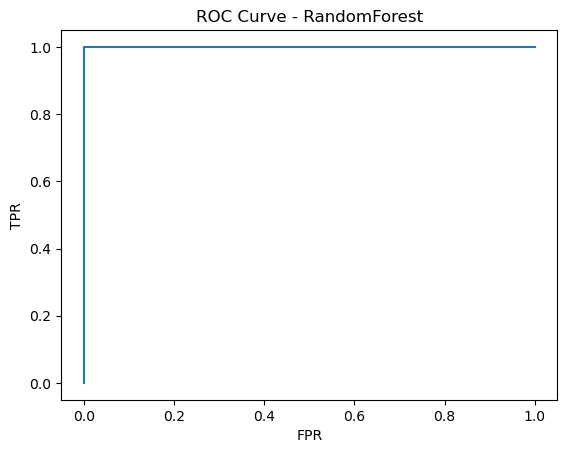

In [97]:
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel('FPR'); plt.ylabel('TPR')
plt.title(f'ROC Curve - {best_name}')
plt.show()

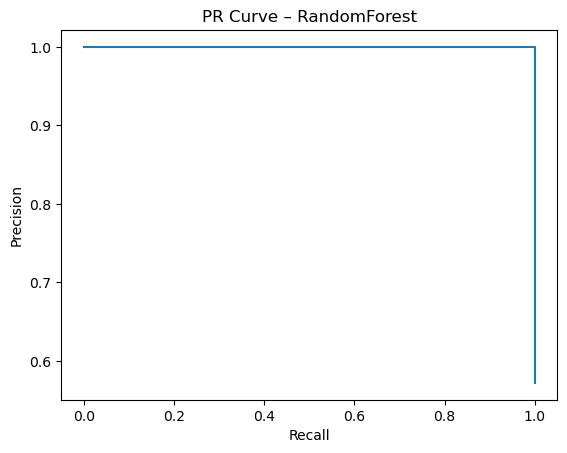

In [99]:
plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"PR Curve – {best_name}")
plt.show()

In [100]:

roc = roc_auc_score(y_test, probs)
pr  = average_precision_score(y_test, probs)

In [101]:
print(f"Final {best_name} ROC-AUC: {roc:.4f}, PR-AUC: {pr:.4f}")


Final RandomForest ROC-AUC: 1.0000, PR-AUC: 1.0000


In [102]:
Path("../models").mkdir(parents=True, exist_ok=True)
joblib.dump(final_model, f"../models/{best_name}_url_model.pkl")
print(f"Saved {best_name} model to ../models/")

Saved RandomForest model to ../models/
